In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
    plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
    plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
    plt.xlabel("ISI duration (s)")
    plt.ylabel("Number of spikes")
    plt.legend()

In [5]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
    print('Failed to download data')
else:
    spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [10]:
type(spike_times)
spike_times.shape

(734,)

In [12]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


In [14]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


In [16]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
    print(
        "Neuron {}:".format(i),
        spike_times[i].dtype,
        spike_times[i][i_print],
        "\n",
        sep="\n"
    )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




In [17]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


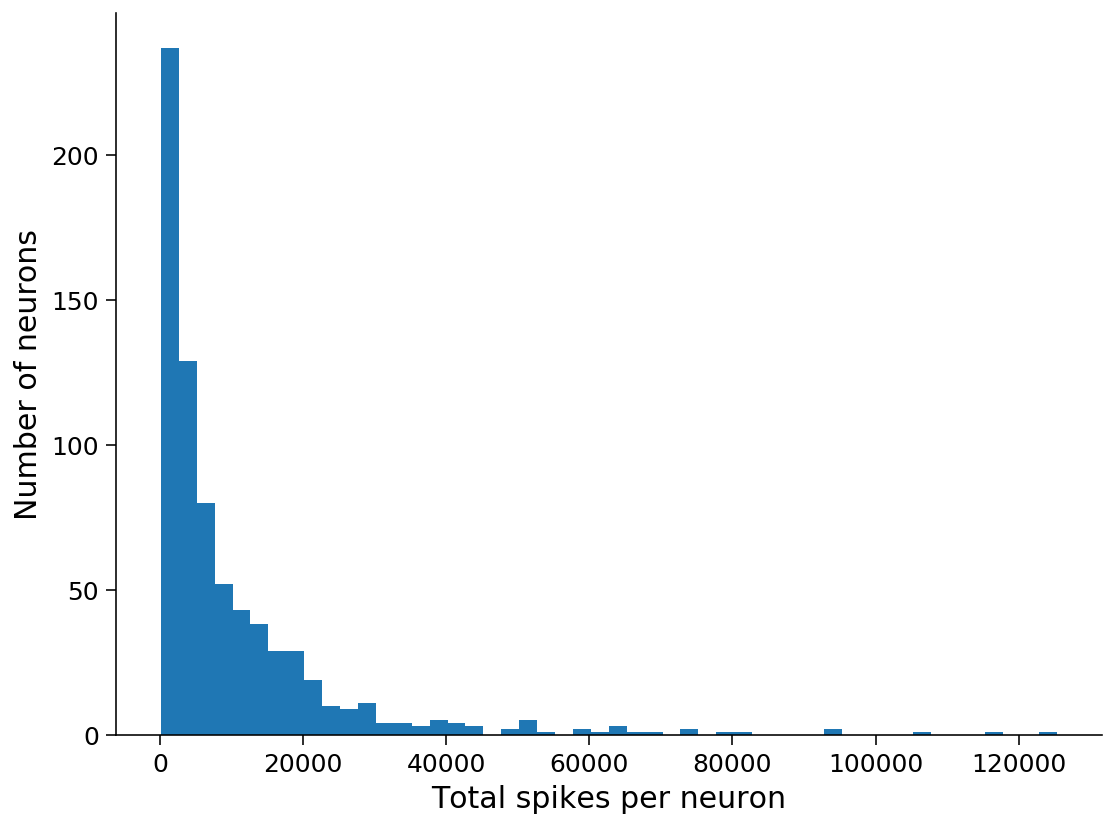

In [18]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [21]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


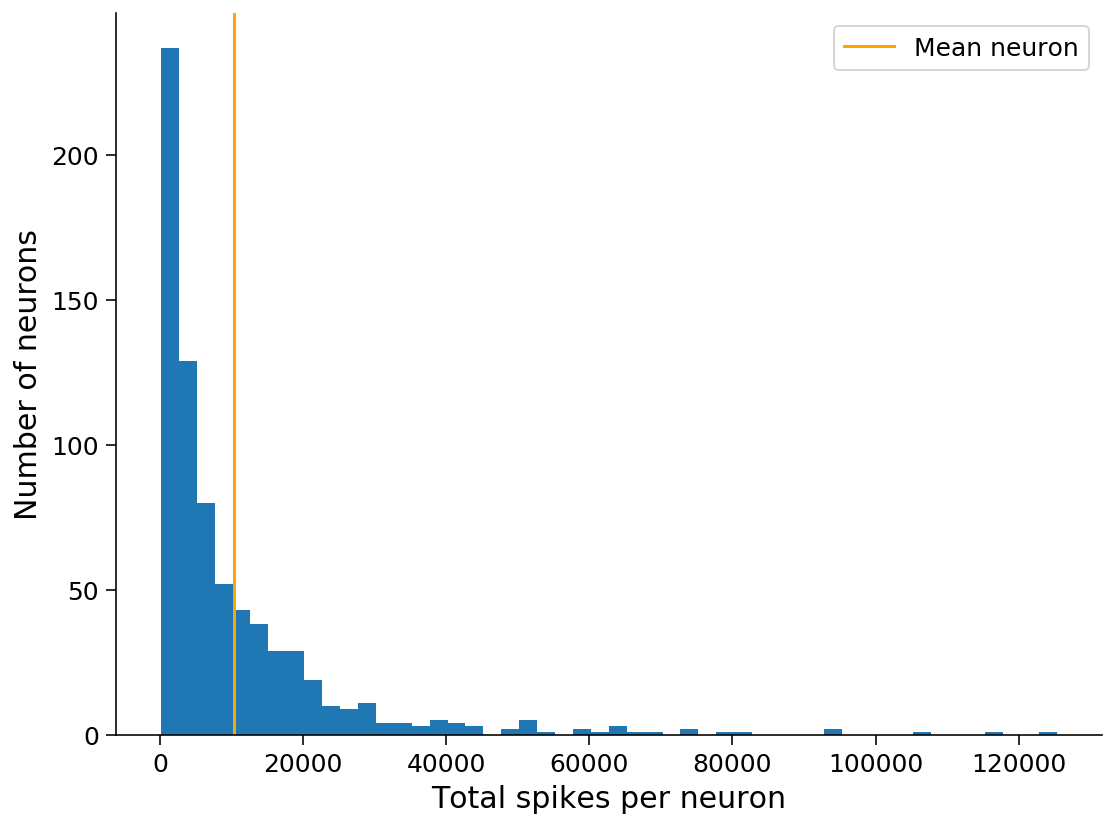

In [25]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

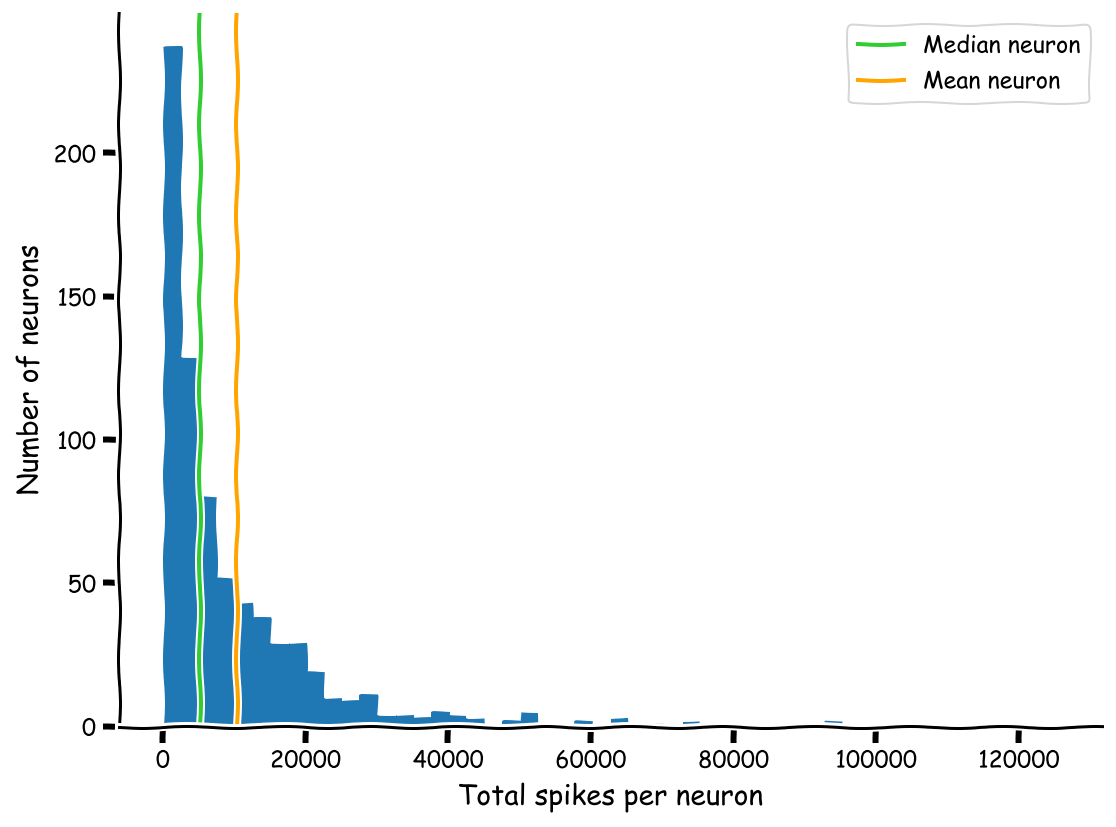

In [26]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median

# Visualize median, mean, and histogram
with plt.xkcd():
    plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
    plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
    plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
    plt.xlabel("Total spikes per neuron")
    plt.ylabel("Number of neurons")
    plt.legend()

In [30]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
    """Given a spike_time dataset, restrict to spikes within given interval.

    Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

    Returns:
    np.ndarray: like `spike_times`, but only within `interval`
    """
    interval_spike_times = []
    for spikes in spike_times:
        interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
        interval_spike_times.append(spikes[interval_mask])
    return np.array(interval_spike_times, object)

In [42]:
t_interval = (0, 100)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

3.33% of the total spikes are in the interval


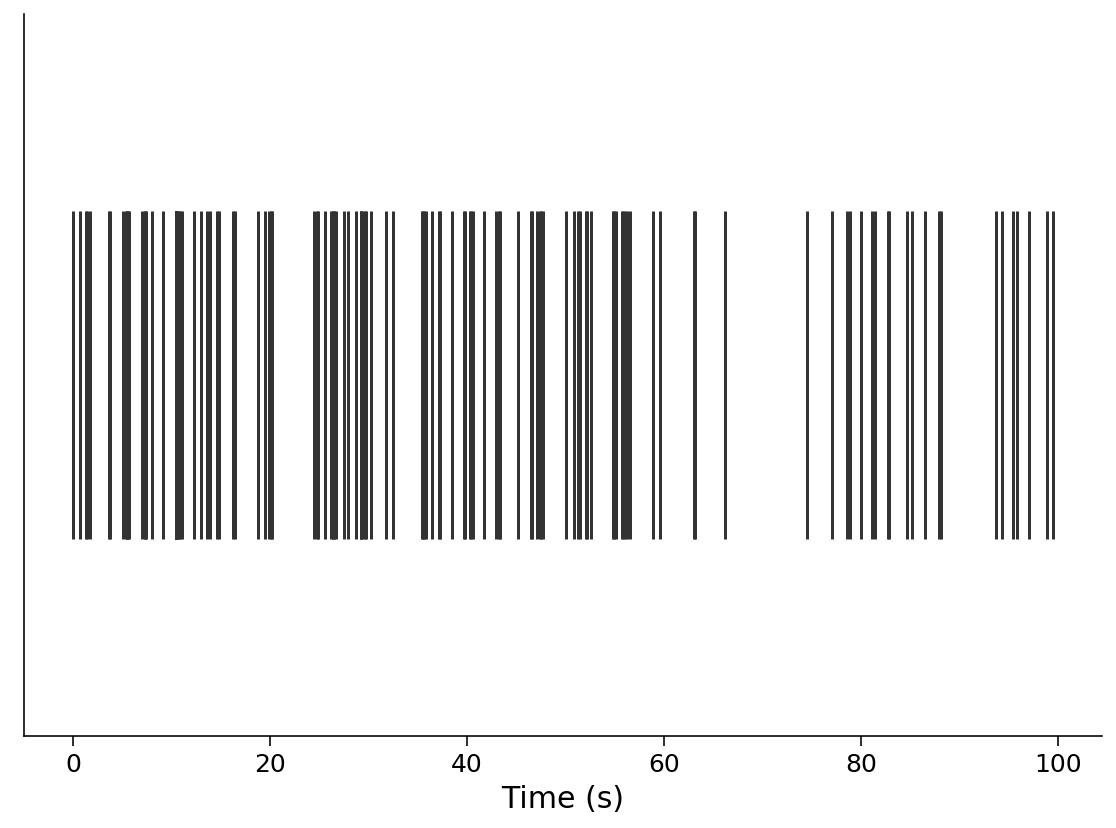

In [43]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);


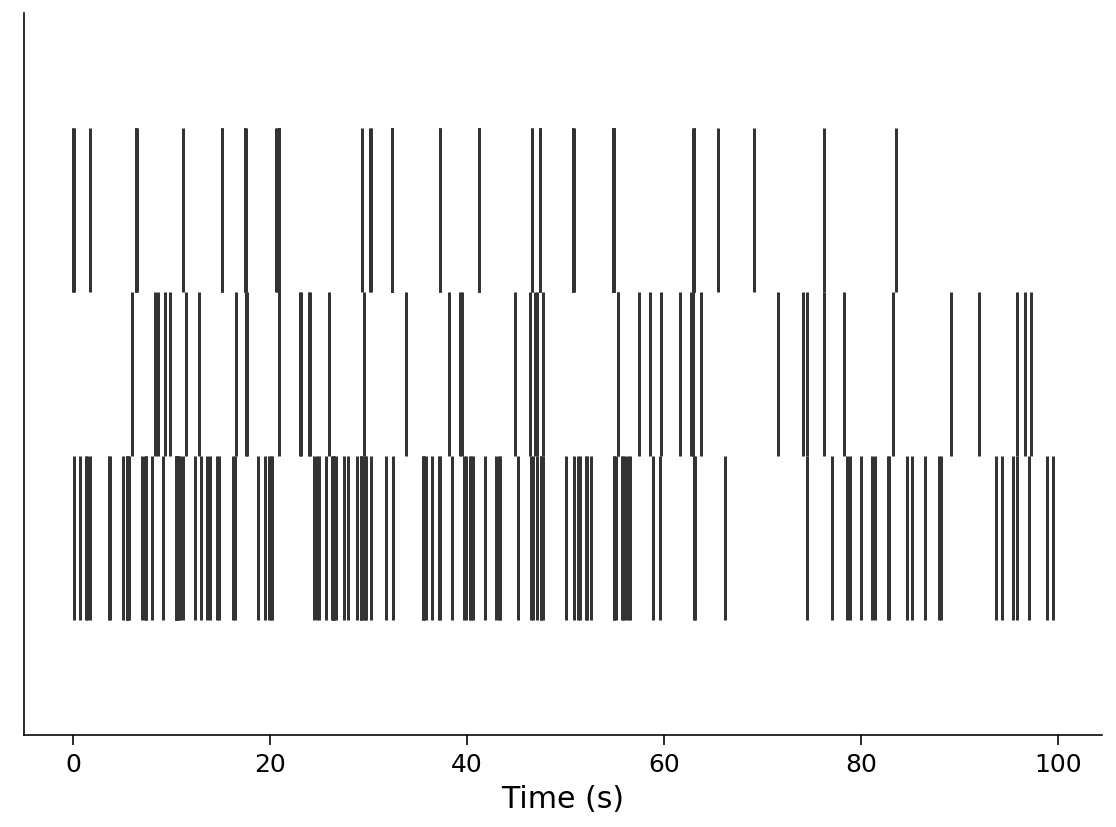

In [44]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

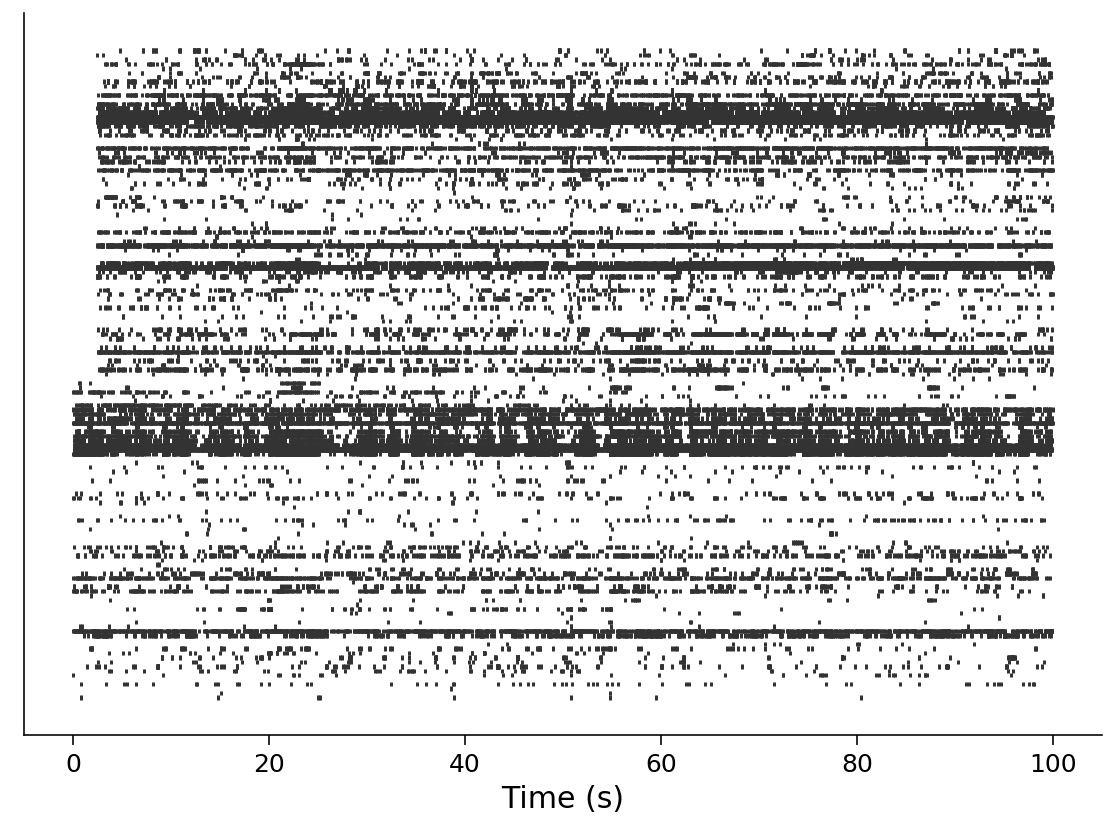

In [45]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

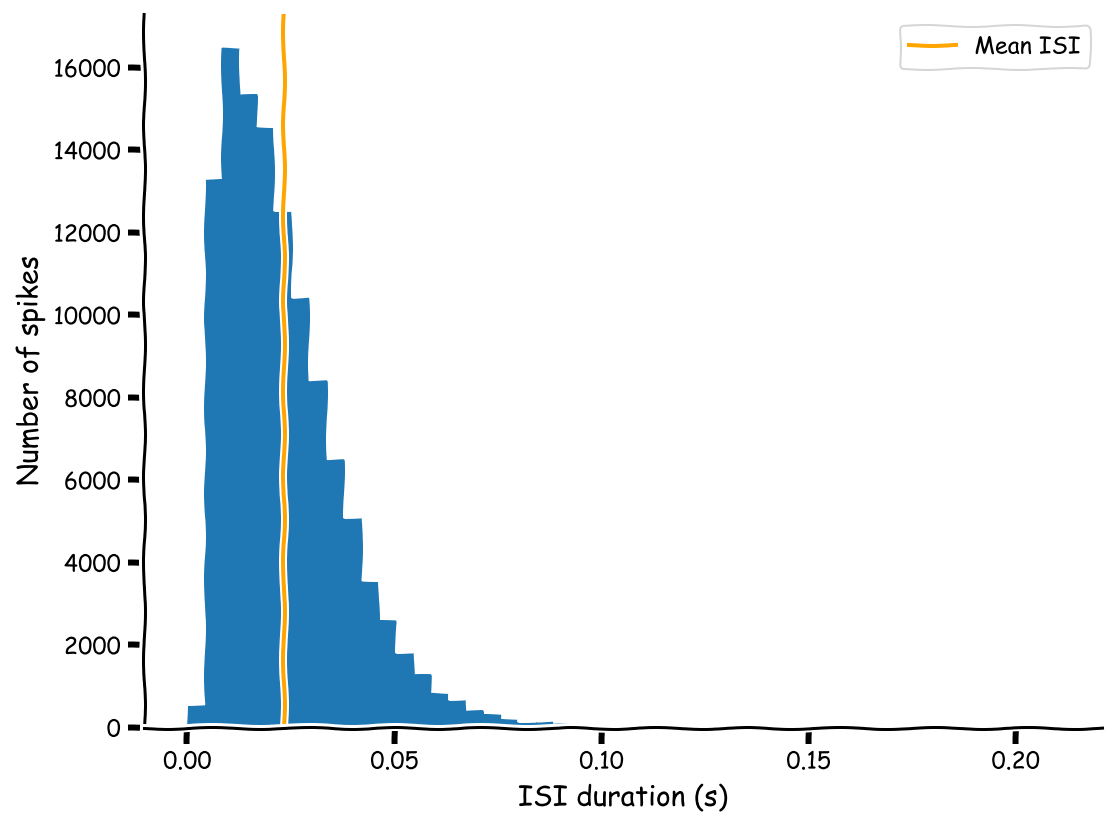

In [48]:
def compute_single_neuron_isis(spike_times, neuron_idx):
    """Compute a vector of ISIs for a single neuron given spike times.
    Args:
        spike_times (list of 1D arrays): Spike time dataset, with the first
            dimension corresponding to different neurons.
        neuron_idx (int): Index of the unit to compute ISIs for.
    Returns:
    isis (1D array): Duration of time between each spike from one neuron.
    """
    # Extract the spike times for the specified neuron
    single_neuron_spikes = spike_times[neuron_idx]

    # Compute the ISIs for this set of spikes
    # Hint: the function np.diff computes discrete differences along an array
    isis = np.diff(single_neuron_spikes)

    return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
with plt.xkcd():
    plot_isis(single_neuron_isis)

In [50]:
def exponential(xs, scale, rate, x0):
    """A simple parametrized exponential function, applied element-wise.

    Args:
        xs (np.ndarray or float): Input(s) to the function.
        scale (float): Linear scaling factor.
        rate (float): Exponential growth (positive) or decay (negative) rate.
        x0 (float): Horizontal offset.

    """
    ys = scale * np.exp(rate * (xs - x0))
    return ys

def inverse(xs, scale, x0):
    """A simple parametrized inverse function (`1/x`), applied element-wise.

    Args:
        xs (np.ndarray or float): Input(s) to the function.
        scale (float): Linear scaling factor.
        x0 (float): Horizontal offset.

    """
    ys = scale / (xs - x0)
    return ys

def linear(xs, slope, y0):
    """A simple linear function, applied element-wise.

    Args:
        xs (np.ndarray or float): Input(s) to the function.
        slope (float): Slope of the line.
        y0 (float): y-intercept of the line.

    """
    ys = slope * xs + y0
    return ys

In [51]:
#@title

#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
    single_neuron_isis,
    bins=50,
    range=(0, single_neuron_isis.max())
)

functions = dict(
    exponential=exponential,
    inverse=inverse,
    linear=linear,
)

colors = dict(
    exponential="C1",
    inverse="C2",
    linear="C4",
)

@widgets.interact(
    exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
    exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
    exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
    inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
    inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
    lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
    lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
    exp_scale=1000, exp_rate=-10, exp_x0=0.1,
    inv_scale=1000, inv_x0=0,
    lin_slope=-1e5, lin_y0=2000,
):
    """Helper function for plotting function fits with interactive sliders."""
    func_params = dict(
        exponential=(exp_scale, exp_rate, exp_x0),
        inverse=(inv_scale, inv_x0),
        linear=(lin_slope, lin_y0),
    )
    f, ax = plt.subplots()
    ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
    xs = np.linspace(1e-10, edges.max())
    for name, function in functions.items():
        ys = function(xs, *func_params[name])
        ax.plot(xs, ys, lw=3, color=colors[name], label=name);
    ax.set(
        xlim=(edges.min(), edges.max()),
        ylim=(0, counts.max() * 1.1),
        xlabel="ISI (s)",
        ylabel="Number of spikes",
    )
    ax.legend()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…